Part 1: Install Required Dependencies

In [1]:
import tensorflow as tf
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Remove non-image files

In [3]:
import cv2
import imghdr

C:\Users\GR DESAI\AppData\Local\Temp\ipykernel_2300\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [4]:
data_dir = "data"

In [5]:
image_exts = ["jpeg", "jpg", "bmp", "png"]

In [6]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)

            if tip not in image_exts:
                print("Removing non-image file: {}".format(image_path))
                os.remove(image_path)

        except Exception as e:
            print("Issue with image {}: {}".format(image_path, str(e)))

Load Data

In [7]:
import numpy as np
from matplotlib import pyplot as plt

In [8]:
data = tf.keras.utils.image_dataset_from_directory("data")

Found 1788 files belonging to 2 classes.


In [9]:
data_iterator = iter(data)


In [10]:
batch = next(data_iterator)

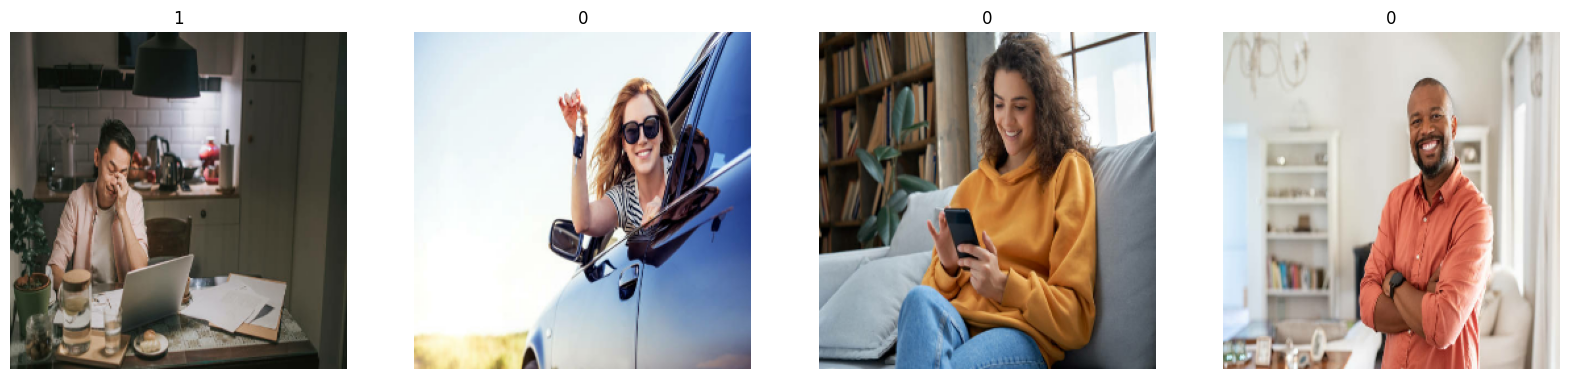

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(tf.squeeze(img).numpy().astype(np.uint8))
    ax[idx].set_title(batch[1][idx].numpy())
    ax[idx].axis("off")

plt.show()


Part 2: Preprocessing data

Scaling data

In [12]:
scaled_Data = data.map(lambda x, y: (x/255, y))
scaled_iterator = scaled_Data.as_numpy_iterator()
scaled_batch = scaled_iterator.next()

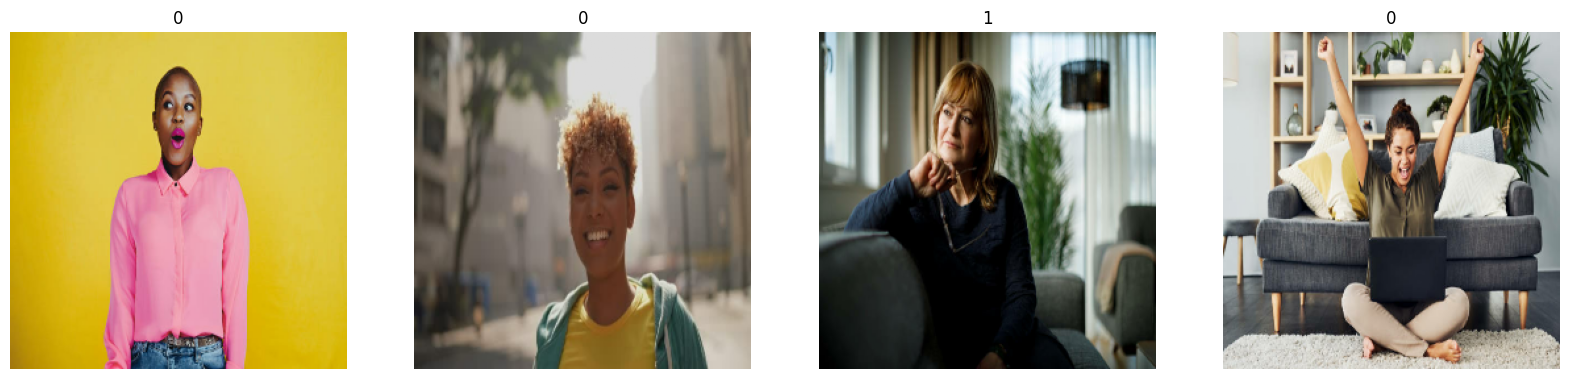

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(scaled_batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].set_title(scaled_batch[1][idx])
    ax[idx].axis("off")

plt.show()

Split data

In [14]:
train_size = int(len(scaled_Data)*.7)
val_size = int(len(scaled_Data)*.2)+1
test_size = int(len(scaled_Data)*.1)

In [15]:
train = scaled_Data.take(train_size)
val = scaled_Data.skip(train_size).take(val_size)
test = scaled_Data.skip(train_size+val_size).take(test_size)

Part 3: Deep modelling

Build deep learing model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [17]:
model = Sequential()

In [19]:
model.add(Conv2D(16, (3,3), 1, activation="relu", input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

C:\Users\GR DESAI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [20]:
# Build the model
model.build(input_shape=(None, 256, 256, 3))

In [21]:
model.compile("adam", loss=tf.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

Train

In [23]:
logdir = "logs"

In [24]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [25]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


39/39 ━━━━━━━━━━━━━━━━━━━━ 28s 588ms/step - accuracy: 0.5022 - loss: 0.8113 - val_accuracy: 0.5651 - val_loss: 0.6774
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 536ms/step - accuracy: 0.5961 - loss: 0.6660 - val_accuracy: 0.6562 - val_loss: 0.6112
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 593ms/step - accuracy: 0.6840 - loss: 0.5912 - val_accuracy: 0.6745 - val_loss: 0.6183
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 537ms/step - accuracy: 0.7497 - loss: 0.5192 - val_accuracy: 0.7630 - val_loss: 0.4879
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 557ms/step - accuracy: 0.8260 - loss: 0.3956 - val_accuracy: 0.7630 - val_loss: 0.4736
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 549ms/step - accuracy: 0.8763 - loss: 0.2922 - val_accuracy: 0.8750 - val_loss: 0.3723
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 28s 710ms/step - accuracy: 0.9547 - loss: 0.1438 - val_accuracy: 0.8542 - val_loss: 0.3892
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 604ms/step - accuracy: 0.9702 - loss: 0.1000 - val_accuracy: 0.880

Plot Performance

In [26]:
hist.history

{'accuracy': [0.5248397588729858,
  0.625,
  0.6875,
  0.7612179517745972,
  0.8333333134651184,
  0.8878205418586731,
  0.9463140964508057,
  0.96875,
  0.9863781929016113,
  0.995192289352417,
  0.9967948794364929,
  0.9991987347602844,
  0.9991987347602844,
  0.9991987347602844,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9991987347602844,
  0.9935897588729858],
 'loss': [0.7350157499313354,
  0.6453316807746887,
  0.5869714021682739,
  0.506999135017395,
  0.38698461651802063,
  0.27416402101516724,
  0.1502363383769989,
  0.10484683513641357,
  0.06463821232318878,
  0.03135121613740921,
  0.024848686531186104,
  0.00892340112477541,
  0.006255753338336945,
  0.009778876788914204,
  0.0031159804202616215,
  0.0009950496023520827,
  0.0008340479689650238,
  0.0006578259053640068,
  0.004878707230091095,
  0.027961602434515953],
 'val_accuracy': [0.5651041865348816,
  0.65625,
  0.6744791865348816,
  0.7630208134651184,
  0.7630208134651184,
  0.875,
  0.8541666865348816,
  0.8802083134651184,


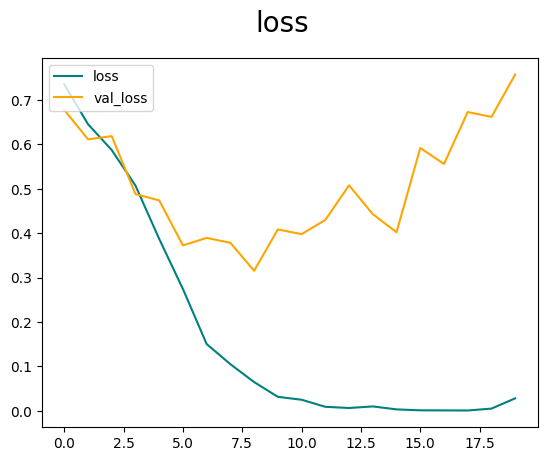

In [27]:
fig = plt.figure()
plt.plot(hist.history["loss"], color="teal", label="loss")
plt.plot(hist.history["val_loss"], color="orange", label="val_loss")
fig.suptitle("loss", fontsize=20)
plt.legend(loc="upper left")
plt.show()

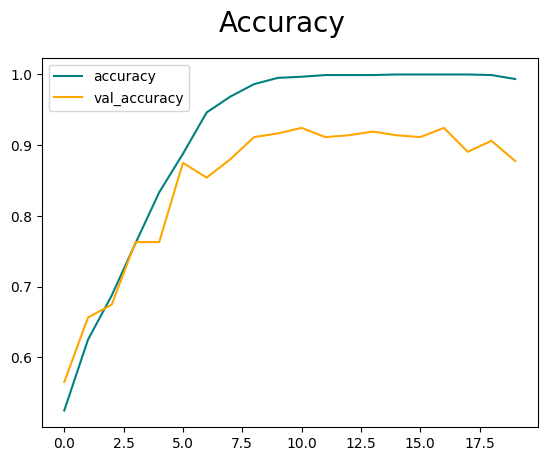

In [28]:
fig = plt.figure()
plt.plot(hist.history["accuracy"], color="teal", label="accuracy")
plt.plot(hist.history["val_accuracy"], color="orange", label="val_accuracy")
fig.suptitle("Accuracy", fontsize=20)
plt.legend(loc="upper left")
plt.show()

Part 4: Evaluvating Performance

Evavulate

In [29]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [30]:
len(test)

5

In [31]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [32]:
for temp_batch in test.as_numpy_iterator():
    x, y = temp_batch
    yhat = model.predict(x)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


In [33]:
print(f"Precision: {pre.result().numpy()}   Recall: {re.result().numpy()}   Accuracy: {acc.result().numpy()}")

Precision: 0.855555534362793   Recall: 0.895348846912384   Accuracy: 0.8589743375778198


Part 5:Save the model

Save the model

In [36]:
from tensorflow.keras.models import load_model

In [37]:
model.save(os.path.join("models", "happy_sad_model_2.h5"))